In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import matplotlib.gridspec as gridspec

# from spacepy import coordinates as coord
# from spacepy.time import Ticktock

# from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
# from mpl_toolkits.mplot3d import Axes3D

import xflib as xflib

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')

R2D = 180./np.pi
D2R = np.pi/180.
%matplotlib inline
# %matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [3]:
''' This block loads the matlab coastline file (in magnetic coordinates), and generates
    polar and equatorial views. Details! '''

# Load coastlines (for plotting)
with gzip.open('python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
coastpoints = np.vstack([coast['lon'], coast['lat']])

coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 90.) | (np.isnan(coastr))


## ---- Polar view ----
centerpoint = [0,90] # longitude, latitude

# distance from centerpoint in earth radii (haversine formula)
dlat = coastpoints[1,:] -centerpoint[1]
dlon = coastpoints[0,:] -centerpoint[0]
clat1 = np.cos(D2R*coastpoints[1,:])
clat2 = np.cos(D2R*centerpoint[1])
a = pow(np.sin(D2R*dlat/2.0),2)
b = (clat1*clat2*pow(np.sin(D2R*dlon/2.0),2))
gc_distance = 2.0* np.arcsin(np.sqrt(a + b)) 

maxdist = 1.0 #0.8

np_mask = ( (np.abs(gc_distance) < maxdist) & (coastpoints[0,:] < 180.)) | np.isnan(gc_distance)

XYcoast = np.vstack([gc_distance[np_mask]*np.cos(coastpoints[0,np_mask]*D2R)/maxdist,
                      gc_distance[np_mask]*np.sin(coastpoints[0,np_mask]*D2R)/maxdist])

## ---- Solar plane view ----
centerpoint = [0,30] # longitude, latitude

# distance from centerpoint in earth radii (haversine formula)
dlat = coastpoints[1,:] -centerpoint[1]
dlon = coastpoints[0,:] -centerpoint[0]
clat1 = np.cos(D2R*coastpoints[1,:])
clat2 = np.cos(D2R*centerpoint[1])
a = pow(np.sin(D2R*dlat/2.0),2)
b = (clat1*clat2*pow(np.sin(D2R*dlon/2.0),2))
gc_distance = 2.0* np.arcsin(np.sqrt(a + b)) 

maxdist = 1.3

ta = centerpoint[1]
tb = coastpoints[1,:]
dl = coastpoints[0,:] - centerpoint[0]
X = np.cos(D2R*tb)*np.sin(D2R*dl)
Y = np.cos(D2R*ta)*np.sin(D2R*tb) - np.sin(D2R*ta)*np.cos(D2R*tb)*np.cos(D2R*dl)
beta = np.arctan2(X,Y) + np.pi/2.

np_mask = (np.abs(gc_distance) < maxdist) | np.isnan(gc_distance)
XZcoast = np.vstack([gc_distance[np_mask]*np.cos(beta[np_mask])/maxdist,
                      gc_distance[np_mask]*np.sin(beta[np_mask])/maxdist])

## ---- Perpendicular plane view ----
centerpoint = [90,30] # longitude, latitude

# distance from centerpoint in earth radii (haversine formula)
dlat = coastpoints[1,:] -centerpoint[1]
dlon = coastpoints[0,:] -centerpoint[0]
clat1 = np.cos(D2R*coastpoints[1,:])
clat2 = np.cos(D2R*centerpoint[1])
a = pow(np.sin(D2R*dlat/2.0),2)
b = (clat1*clat2*pow(np.sin(D2R*dlon/2.0),2))
gc_distance = 2.0* np.arcsin(np.sqrt(a + b)) 

maxdist = 1.1

ta = centerpoint[1]
tb = coastpoints[1,:]
dl = coastpoints[0,:] - centerpoint[0]
X = np.cos(D2R*tb)*np.sin(D2R*dl)
Y = np.cos(D2R*ta)*np.sin(D2R*tb) - np.sin(D2R*ta)*np.cos(D2R*tb)*np.cos(D2R*dl)
beta = np.arctan2(X,Y) + np.pi/2.

np_mask = (np.abs(gc_distance) < maxdist) | np.isnan(gc_distance)
YZcoast = np.vstack([gc_distance[np_mask]*np.cos(beta[np_mask])/maxdist,
                      gc_distance[np_mask]*np.sin(beta[np_mask])/maxdist])





# # ## ---- test plot ----
# fig, ax = plt.subplots(1,3)
# # Earth circle
# earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
# iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='k',alpha=0.8, zorder=99)
# ax[0].add_patch(earth)   
# ax[0].add_patch(iono)
# ax[0].plot(XYcoast[0,:], XYcoast[1,:],'k', zorder=101, alpha=1, linewidth=0.5)

# earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
# iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='k',alpha=0.8, zorder=99)
# ax[1].add_patch(earth)   
# ax[1].add_patch(iono)
# ax[1].plot(XZcoast[0,:], XZcoast[1,:],'k', zorder=101, alpha=0.6, linewidth=0.5)

# earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
# iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='k',alpha=0.8, zorder=99)
# ax[2].add_patch(earth)   
# ax[2].add_patch(iono)
# ax[2].plot(YZcoast[0,:], YZcoast[1,:],'k', zorder=101, alpha=0.6, linewidth=0.5)





# ax[0].set_aspect('equal')
# ax[1].set_aspect('equal')
# ax[2].set_aspect('equal')

# fig.savefig('sweet_earths.pdf')



Kp =  0 7.98150681167 6.10722722785
Kp =  2 4.80296193404 5.11893314084
Kp =  4 3.74145363494 4.25148331682
Kp =  6 2.89254388851 3.43809307201
Kp =  8 2.05866805608 2.49777808469


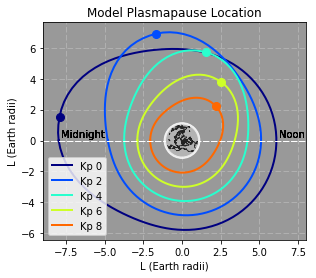

In [14]:
# Constants
Hz2Rad = 2.*np.pi
D2R = np.pi/180.
H_IONO_BOTTOM = 1e5
H_IONO_TOP = 1e6

R_E = 6371e3

def bulge(amlt, akp):
    '''cloning the fortran function here... I think I did this before, but whatever'''
    ahour_rad = 0.26179939
    ahrrad = 2.6179939e-1
    centroid=47.0/(akp+3.9)+11.3
    x=amlt-centroid
    if (x < -12.0):
        x=x+24.0    
    if (x > 12.0):
        x=x-24.0
    absx=abs(x)*ahrrad
    
    along=amlt*ahour_rad+1.5707963
    salong=np.sin(along)
    b1= 0.043*salong-0.4589
    b2=-0.361*salong+5.7464
    a8=(b1*akp+b2)*(1.0+np.exp(-1.5*absx*absx+0.08*absx-0.7))
    b3=-0.0243*salong+0.2464
    b4=-0.3137*salong-5.2214
    b5= 3.5817*salong+48.8114
    a9=b3*akp*akp + b4*akp+b5
    
    return a8, a9, centroid

# --------------- Latex Plot Beautification --------------------------
fig_width = 4  # width in inches
fig_height = 3      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------



fig, ax = plt.subplots(1,1)

# ax.set_facecolor(plt.get_cmap('jet')(0))
ax.set_facecolor('0.6')
earth = plt.Circle((0,0),1,color='0.7',alpha=1, zorder=100)
iono  = plt.Circle((0,0),(R_E + H_IONO_TOP)/R_E, color='w',alpha=0.8, zorder=99)
ax.add_patch(earth)   
ax.add_patch(iono)

# # Load coastlines (for plotting)
# with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
#     coast = pickle.load(file)
# coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
# coastr = np.linalg.norm(coastpoints, axis=0)
# coastmask = (coastr < 1) | (np.isnan(coastr))
# ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.8, linewidth=1)
ax.plot(XYcoast[0,:], XYcoast[1,:],'k', zorder=101, alpha=0.8, linewidth=0.8)







# Plot the oval vs mlt:
mltvec = np.linspace(0,24,100)
Kpvec = [0, 2, 4, 6, 8]

NUM_COLORS = len(Kpvec)

cm = plt.get_cmap('jet')

for Kp_ind, Kp in enumerate(Kpvec):
    Lppvec = np.zeros_like(mltvec)
    for x in range(len(mltvec)):
        L, a9, cent = bulge(mltvec[x],Kp)
        Lppvec[x] = L
    print "Kp = ", Kp, Lppvec[0], Lppvec[50]

    lmax = np.argmax(Lppvec)
    xx = Lppvec*np.cos(mltvec*2.*np.pi/24. + np.pi)
    yy = Lppvec*np.sin(mltvec*2.*np.pi/24.+ np.pi)
    color = cm(1.0*Kp_ind/NUM_COLORS)
    ax.plot(xx,yy,linewidth=2, color=color,  label='Kp %d'%Kp)
    
    # Dot the maximum value:
    ax.plot(xx[lmax], yy[lmax],'o', color=color, markersize=8)
    
    ax.grid('on', linestyle='--', linewidth=1, zorder=99)
    ax.set_aspect('equal')
    ax.set_xlim([-9,8])
#     ax.set_ylim([-8,8])

    ax.plot([-9, 9], [0, 0],'--', linewidth=1, color='w')
    ax.text(6.3,0.2,'Noon')
    ax.text(-7.8,0.2,'Midnight')


    ax.legend()
    ax.set_title('Model Plasmapause Location')
    
    ax.set_xlabel('L (Earth radii)')
    ax.set_ylabel('L (Earth radii)')
    
#     fig.savefig('plasmapause.png', dpi=150)
    fig.savefig('plasmapause.pdf')

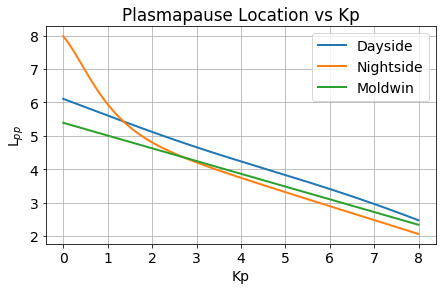

In [5]:
# Compare noon and midnight slices:
# --------------- Latex Plot Beautification --------------------------
fig_width = 6  # width in inches
fig_height = 3      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

Kpvec = np.arange(0, 8, 0.01)
nite = np.zeros_like(Kpvec)
day = np.zeros_like(Kpvec)
for K_ind, Kp in enumerate(Kpvec):
    Ln, _, _ = bulge(0, Kp)
    Ld, _, _ = bulge(12,Kp)
    nite[K_ind] = Ln
    day[K_ind] = Ld

# Moldwin 2002 model of the plasmapause location
moldwin = 5.39 - 0.382*Kpvec
fig, ax = plt.subplots(1,1)
ax.plot(Kpvec, day, linewidth=2,label='Dayside')
ax.plot(Kpvec,nite, linewidth=2,label='Nightside')
ax.plot(Kpvec, moldwin, linewidth=2, label='Moldwin')
ax.grid('on',which='both')
ax.set_xlabel('Kp')
ax.set_ylabel('L$_{pp}$')
ax.legend()
ax.set_title('Plasmapause Location vs Kp')

fig.savefig('Plasmapuse_vs_Kp.png', dpi=150)